**SHEET1**

In [29]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, explained_variance_score,
    median_absolute_error, max_error, mean_squared_log_error
)
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

In [7]:
df = pd.read_csv("carbon emissions data - Sheet1.csv")
df

,EDGAR Country Code,Country,1970,1971,1972,1973,1974,1975,1976,1977,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,IND,India,733.244112,739.102382,751.027711,758.952065,780.709496,814.212735,836.784745,858.754954,...,3310.459112,3353.918433,3495.501455,3634.422874,3641.293161,3461.050022,3719.56317,3961.525613,4206.328902,4371.169327
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Keep only first row (India)
row = df.iloc[0]

# Extract year columns (1970–2024)
years = [str(y) for y in range(1970, 2025)]
ts = row[years].astype(float)

# Convert to pandas time-series
ts.index = pd.to_datetime(ts.index, format="%Y")


In [9]:
ts

1970-01-01     733.244112
1971-01-01     739.102382
1972-01-01     751.027711
1973-01-01     758.952065
1974-01-01     780.709496
1975-01-01     814.212735
1976-01-01     836.784745
1977-01-01     858.754954
1978-01-01     863.229991
1979-01-01     888.530163
1980-01-01     921.674550
1981-01-01     970.879889
1982-01-01     996.430255
1983-01-01    1047.382225
1984-01-01    1101.198495
1985-01-01    1133.780240
1986-01-01    1195.647602
1987-01-01    1231.553587
1988-01-01    1302.096886
1989-01-01    1360.501330
1990-01-01    1353.652585
1991-01-01    1412.268650
1992-01-01    1445.596919
1993-01-01    1478.086996
1994-01-01    1532.694654
1995-01-01    1596.657738
1996-01-01    1644.435448
1997-01-01    1700.969840
1998-01-01    1731.402897
1999-01-01    1800.687347
2000-01-01    1835.559651
2001-01-01    1859.448711
2002-01-01    1888.198639
2003-01-01    1938.225641
2004-01-01    2040.761493
2005-01-01    2111.742985
2006-01-01    2216.196245
2007-01-01    2359.310870
2008-01-01  

In [10]:
train = ts[:'2014']
test = ts['2015':]

In [11]:
def compute_metrics(y_true, y_pred):
    # Ensure index alignment and numpy arrays
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    metrics = {}

    # Core errors
    metrics["MSE"] = mean_squared_error(y_true, y_pred)
    metrics["RMSE"] = np.sqrt(metrics["MSE"])

    # guard MSLE from <=0
    eps = 1e-9
    y_true_pos = np.maximum(y_true, eps)
    y_pred_pos = np.maximum(y_pred, eps)
    metrics["MSLE"] = mean_squared_log_error(y_true_pos, y_pred_pos)

    metrics["MAE"] = mean_absolute_error(y_true, y_pred)

    # avoid division by zero in MAPE
    metrics["MAPE"] = np.mean(np.abs((y_true - y_pred) / y_true_pos)) * 100.0

    # ✅ Add Accuracy (1 - MAPE)
    metrics["ACCURACY"] = 100.0 - metrics["MAPE"]

    metrics["MEDIAN AE"] = median_absolute_error(y_true, y_pred)
    metrics["MAX ERROR"] = max_error(y_true, y_pred)

    metrics["R2 SCORE"] = r2_score(y_true, y_pred)
    metrics["EVS"] = explained_variance_score(y_true, y_pred)

    return metrics


In [12]:
# ------------------------
# Model 1: Naïve (last observed)
# ------------------------
def naive_forecast(train_series, horizon):
    return np.repeat(train_series.iloc[-1], horizon)

# ------------------------
# Model 2: Simple Mean
# ------------------------
def mean_forecast(train_series, horizon):
    return np.repeat(train_series.mean(), horizon)

# ------------------------
# Model 3: Moving Average (window=3 using only train data)
# ------------------------
def moving_average_forecast(train_series, horizon, window=3):
    last_ma = train_series.rolling(window).mean().dropna().iloc[-1]
    return np.repeat(last_ma, horizon)

# ------------------------
# Model 4 & 5: Holt's Linear Trend / ETS (same API here)
# ------------------------
def holt_linear_forecast(train_series, horizon):
    model = ExponentialSmoothing(train_series, trend="add", seasonal=None)
    fit = model.fit()
    return fit.forecast(horizon), fit

# ------------------------
# Model 6: ARIMA - pick order by simple AIC search over small grid
# ------------------------
def best_arima_forecast(train_series, horizon, pdq_grid=None):
    if pdq_grid is None:
        pdq_grid = [(p,d,q) for p in range(0,3) for d in range(0,2) for q in range(0,3)]
    best_aic = np.inf
    best_order = None
    best_fit = None
    for order in pdq_grid:
        try:
            fit = ARIMA(train_series, order=order).fit()
            if fit.aic < best_aic:
                best_aic = fit.aic
                best_order = order
                best_fit = fit
        except Exception:
            continue
    if best_fit is None:
        # Fallback
        best_fit = ARIMA(train_series, order=(1,1,1)).fit()
        best_order = (1,1,1)
    forecast = best_fit.forecast(horizon)
    return forecast, best_fit, best_order, best_aic

# ------------------------
# ML feature engineering: lags
# ------------------------
def make_supervised(series, lags=3):
    df_sup = pd.DataFrame({"y": series})
    for L in range(1, lags+1):
        df_sup[f"lag{L}"] = series.shift(L)
    df_sup["t"] = np.arange(len(df_sup))  # time index as a feature
    return df_sup.dropna()

def recursive_ml_forecast(series_train, horizon, model, lags=3):
    # Train supervised on train segment
    sup = make_supervised(series_train, lags=lags)
    X = sup.drop(columns=["y"]).values
    y = sup["y"].values
    model.fit(X, y)

    # Prepare last known lags
    history = list(series_train.values[-lags:])
    preds = []
    # start time index after the last train index
    t0 = len(series_train)
    for h in range(horizon):
        features = []
        # lags
        for L in range(1, lags+1):
            features.append(history[-L])
        # time index
        features.append(t0 + h)  # growing time step
        Xh = np.array(features).reshape(1, -1)
        yhat = model.predict(Xh)[0]
        preds.append(yhat)
        history.append(yhat)
    return np.array(preds), model

# ------------------------
# Fit all models and gather forecasts
# ------------------------
H = len(test)
models_forecasts = {}
fitted_objects = {}

In [13]:
# Naive
models_forecasts["Naive"] = naive_forecast(train, H)


In [14]:
# Mean
models_forecasts["Mean"] = mean_forecast(train, H)

In [15]:
models_forecasts["MovingAvg(3)"] = moving_average_forecast(train, H, window=3)


In [16]:
# Holt's Linear
holt_forecast_vals, holt_fit = holt_linear_forecast(train, H)
models_forecasts["HoltLinear"] = np.asarray(holt_forecast_vals)
fitted_objects["HoltLinear"] = holt_fit


In [17]:
# ARIMA (AIC search)
arima_forecast_vals, arima_fit, arima_order, arima_aic = best_arima_forecast(train, H)
models_forecasts["ARIMA"] = np.asarray(arima_forecast_vals)
fitted_objects["ARIMA"] = arima_fit
best_arima_info = {"order": arima_order, "aic": arima_aic}


In [18]:
# ML models
lags = 3

In [19]:
linreg_model = Pipeline([("lr", LinearRegression())])
poly2_model = Pipeline([("poly", PolynomialFeatures(degree=2, include_bias=False)),
                        ("lr", LinearRegression())])
rf_model = RandomForestRegressor(n_estimators=300, random_state=42)
gbr_model = GradientBoostingRegressor(random_state=42)
svr_model = SVR(kernel="rbf", C=10.0, epsilon=0.1)
knn_model = KNeighborsRegressor(n_neighbors=3)


In [20]:
ml_models = {
    "LinearReg(lags)": linreg_model,
    "Poly2Reg(lags)": poly2_model,
    "RandomForest(lags)": rf_model,
    "GradBoost(lags)": gbr_model,
    "SVR(lags)": svr_model,
    "KNN(lags)": knn_model,
}

In [21]:
for name, mdl in ml_models.items():
    preds, fitted = recursive_ml_forecast(train, H, mdl, lags=lags)
    models_forecasts[name] = preds
    fitted_objects[name] = fitted


In [22]:
# Ensure ace_tools is available (fallback to simple display if not)
%pip install ace_tools >/dev/null 2>&1

from IPython.display import display
try:
    from ace_tools import display_dataframe_to_user
except Exception:
    def display_dataframe_to_user(title, df):
        """Fallback display function when ace_tools is not available."""
        print(title)
        display(df)

# Build metrics comparison table
# ------------------------
rows = []
for name, yhat in models_forecasts.items():
    met = compute_metrics(test.values, yhat)
    met["Model"] = name
    rows.append(met)

metrics_df = pd.DataFrame(rows).set_index("Model").sort_values("RMSE")

# Display metrics as an interactive table (uses ace_tools if available, otherwise fallback)
display_dataframe_to_user("Forecasting Model Metrics (2015–2024 test set)", metrics_df.round(4))

# Save to CSV for download
metrics_path = "/home/karan/pyKaran/CarbonEmissions/model_metrics1_2015_2024.csv"
metrics_df.to_csv(metrics_path)
print(f"Model metrics saved to: {metrics_path}")

Note: you may need to restart the kernel to use updated packages.
Forecasting Model Metrics (2015–2024 test set)


,MSE,RMSE,MSLE,MAE,MAPE,ACCURACY,MEDIAN AE,MAX ERROR,R2 SCORE,EVS
Model,,,,,,,,,,
ARIMA,3.705420e+04,1.924947e+02,0.0027,1.446098e+02,4.004900e+00,9.599510e+01,104.7952,4.493165e+02,6.782000e-01,8.290000e-01
HoltLinear,6.877036e+04,2.622410e+02,0.0047,2.199424e+02,5.969300e+00,9.403070e+01,155.3419,5.375095e+02,4.027000e-01,8.229000e-01
LinearReg(lags),2.325540e+05,4.822385e+02,0.0137,4.196672e+02,1.102740e+01,8.897260e+01,473.4122,7.296426e+02,-1.019800e+00,5.099000e-01
Naive,3.278502e+05,5.725821e+02,0.0244,4.612069e+02,1.171680e+01,8.828320e+01,383.5417,1.116853e+03,-1.847400e+00,0.000000e+00
GradBoost(lags),3.279837e+05,5.726986e+02,0.0244,4.613516e+02,1.172070e+01,8.827930e+01,383.6864,1.116998e+03,-1.848600e+00,0.000000e+00
RandomForest(lags),4.057413e+05,6.369783e+02,0.0312,5.390760e+02,1.382920e+01,8.617080e+01,461.4108,1.194722e+03,-2.523900e+00,0.000000e+00
MovingAvg(3),4.674280e+05,6.836871e+02,0.0368,5.935399e+02,1.530670e+01,8.469330e+01,515.8747,1.249186e+03,-3.059700e+00,0.000000e+00
KNN(lags),4.674280e+05,6.836871e+02,0.0368,5.935399e+02,1.530670e+01,8.469330e+01,515.8747,1.249186e+03,-3.059700e+00,0.000000e+00
Mean,4.660384e+06,2.158792e+03,0.7278,2.131958e+03,5.704100e+01,4.295900e+01,2054.2930,2.787604e+03,-3.947640e+01,0.000000e+00


Model metrics saved to: /home/karan/pyKaran/CarbonEmissions/model_metrics1_2015_2024.csv


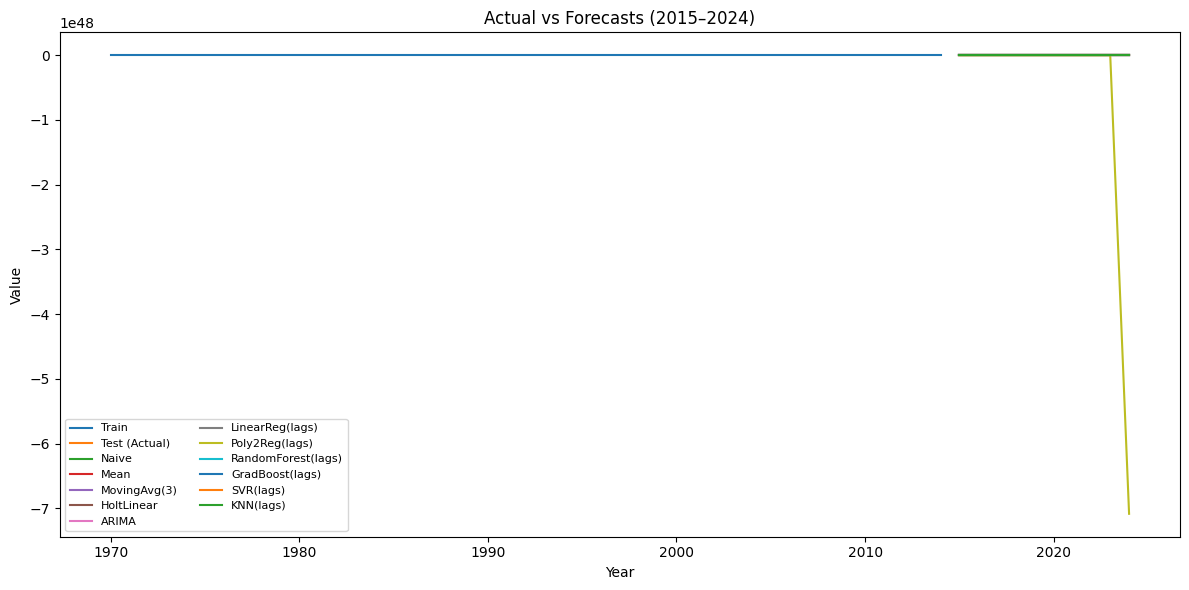

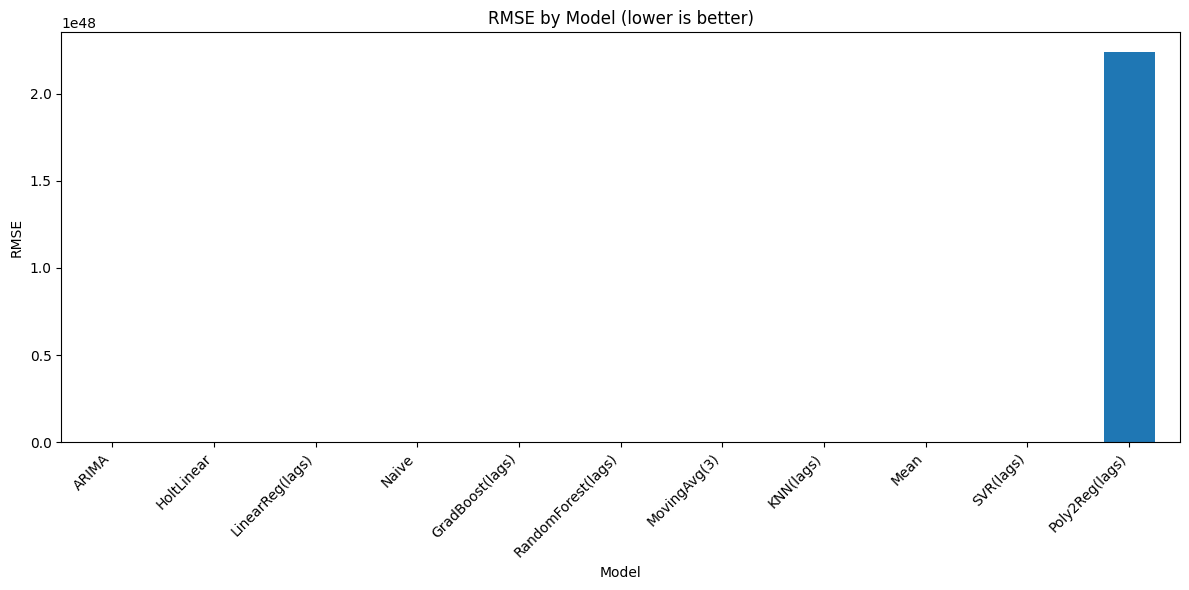

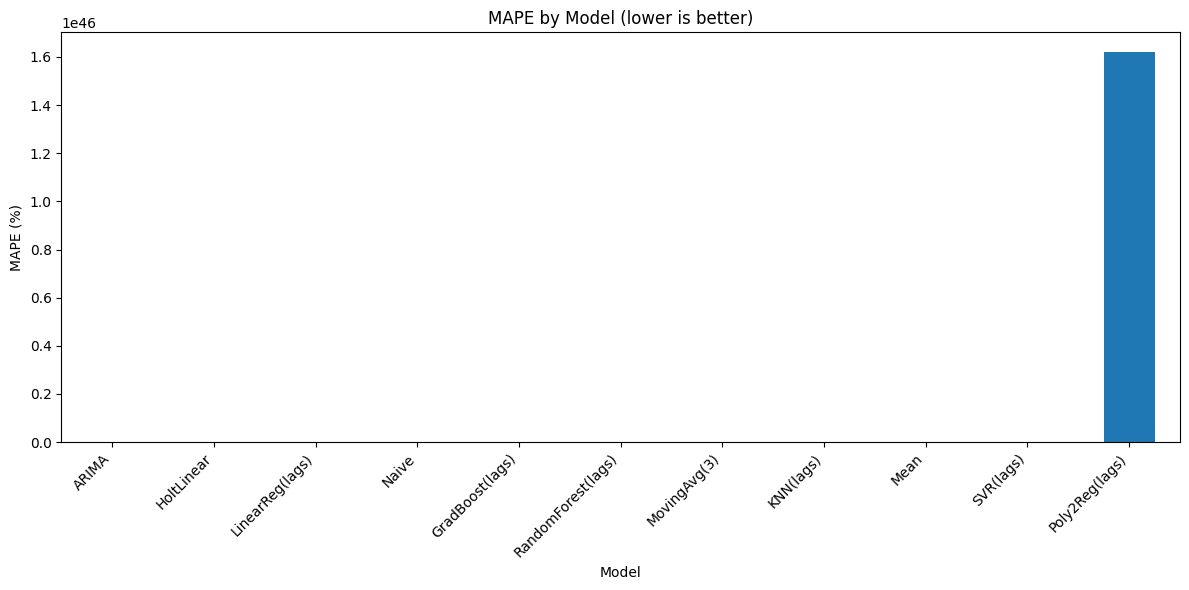

({'order': (1, 1, 2), 'aic': 431.6808624754491},
 '/home/karan/pyKaran/CarbonEmissions/model_metrics1_2015_2024.csv',
 '/home/karan/pyKaran/CarbonEmissions/Sheet1Plots/forecast_comparison.png',
 '/home/karan/pyKaran/CarbonEmissions/Sheet1Plots/rmse_comparison.png',
 '/home/karan/pyKaran/CarbonEmissions/Sheet1Plots/mape_comparison.png',
 ['Naive',
  'Mean',
  'MovingAvg(3)',
  'HoltLinear',
  'ARIMA',
  'LinearReg(lags)',
  'Poly2Reg(lags)',
  'RandomForest(lags)',
  'GradBoost(lags)',
  'SVR(lags)',
  'KNN(lags)'])

In [23]:
# ------------------------
# Plot: Actual vs Forecasts
# ------------------------
plt.figure(figsize=(12,6))
plt.plot(train.index, train.values, label="Train")
plt.plot(test.index, test.values, label="Test (Actual)")
for name, yhat in models_forecasts.items():
    plt.plot(test.index, yhat, label=name)
plt.xlabel("Year")
plt.ylabel("Value")
plt.title("Actual vs Forecasts (2015–2024)")
plt.legend(loc="best", ncol=2, fontsize=8)
plt.tight_layout()
plot1_path = "/home/karan/pyKaran/CarbonEmissions/Sheet1Plots/forecast_comparison.png"
plt.savefig(plot1_path, dpi=150)
plt.show()

# ------------------------
# Plot: RMSE comparison (bar)
# ------------------------
plt.figure(figsize=(12,6))
rmse_vals = metrics_df["RMSE"]
rmse_vals.plot(kind="bar")
plt.ylabel("RMSE")
plt.title("RMSE by Model (lower is better)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plot2_path = "/home/karan/pyKaran/CarbonEmissions/Sheet1Plots/rmse_comparison.png"
plt.savefig(plot2_path, dpi=150)
plt.show()

# ------------------------
# Plot: MAPE comparison (bar)
# ------------------------
plt.figure(figsize=(12,6))
mape_vals = metrics_df["MAPE"]
mape_vals.plot(kind="bar")
plt.ylabel("MAPE (%)")
plt.title("MAPE by Model (lower is better)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plot3_path = "/home/karan/pyKaran/CarbonEmissions/Sheet1Plots/mape_comparison.png"
plt.savefig(plot3_path, dpi=150)
plt.show()

# Also return paths and best ARIMA info for the chat message
metrics_df_head = metrics_df.head(3).to_dict()
(best_arima_info, metrics_path, plot1_path, plot2_path, plot3_path, list(models_forecasts.keys()))

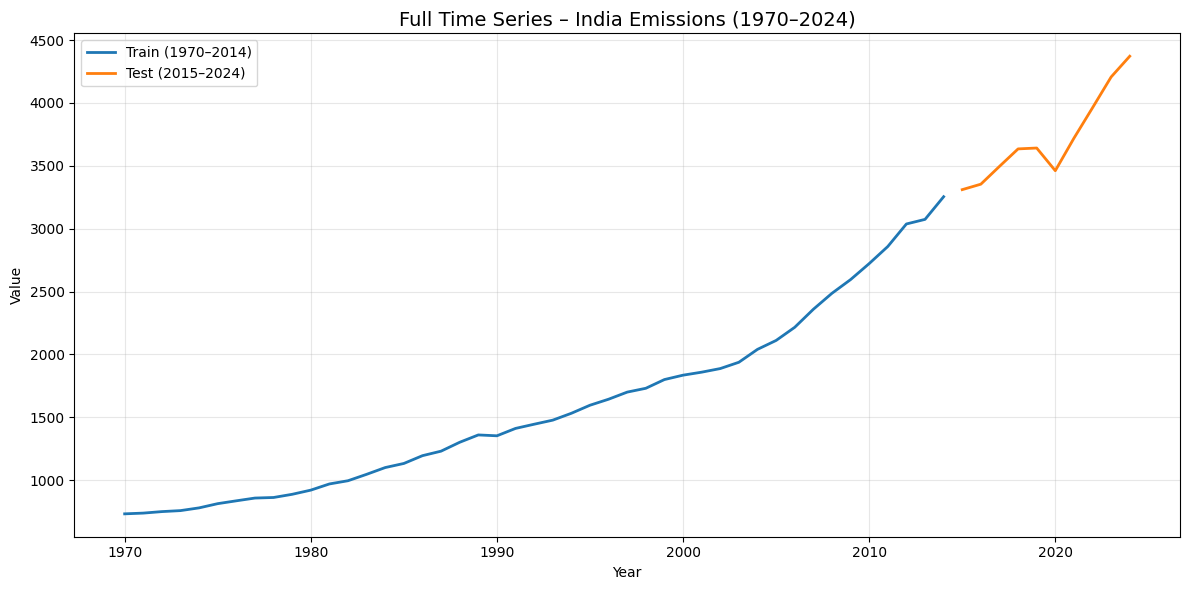

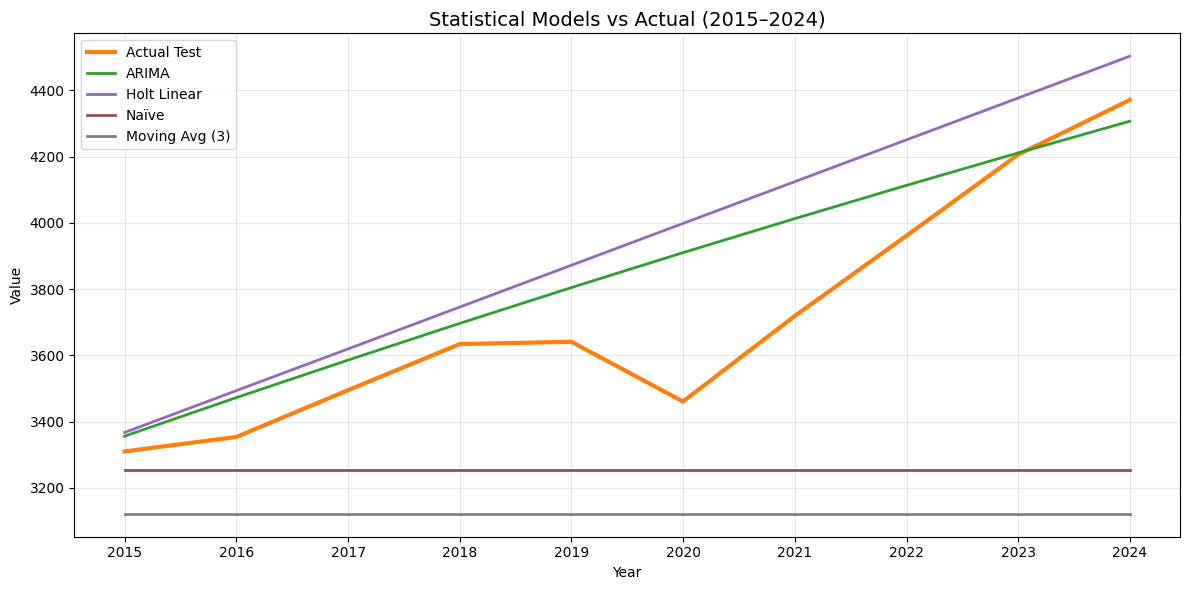

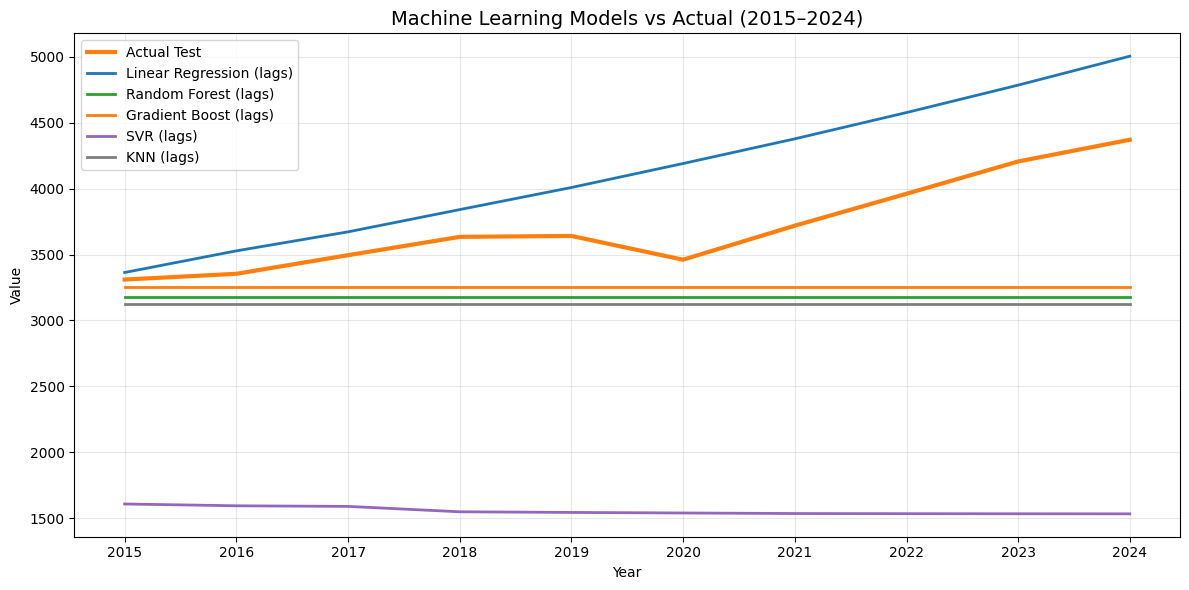

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# ================================
# CORPORATE COLOR PALETTE
# ================================
corp_actual      = "#1f77b4"
corp_train       = "#1f77b4"
corp_test        = "#ff7f0e"

corp_arima       = "#2ca02c"
corp_holt        = "#9467bd"
corp_naive       = "#8c564b"
corp_movavg      = "#7f7f7f"

corp_linreg      = "#1f77b4"
corp_rf          = "#2ca02c"
corp_gb          = "#ff7f0e"
corp_svr         = "#9467bd"
corp_knn         = "#7f7f7f"

# =============================================
# PLOT 1 — FULL TIME SERIES (1970–2024)
# =============================================

plt.figure(figsize=(12,6))
plt.plot(train.index, train.values, color=corp_train, label="Train (1970–2014)", linewidth=2)
plt.plot(test.index, test.values, color=corp_test, label="Test (2015–2024)", linewidth=2)

plt.title("Full Time Series – India Emissions (1970–2024)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Value")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

plt.savefig("/home/karan/pyKaran/CarbonEmissions/Sheet1Plots/dashboard_plot1_full_timeseries.png", dpi=150)
plt.show()


# =============================================
# PLOT 2 — STATISTICAL MODELS vs ACTUAL (2015–2024)
# =============================================

plt.figure(figsize=(12,6))

plt.plot(test.index, test.values, color=corp_test, linewidth=3, label="Actual Test")

plt.plot(test.index, models_forecasts["ARIMA"], color=corp_arima, linewidth=2, label="ARIMA")
plt.plot(test.index, models_forecasts["HoltLinear"], color=corp_holt, linewidth=2, label="Holt Linear")
plt.plot(test.index, models_forecasts["Naive"], color=corp_naive, linewidth=2, label="Naïve")
plt.plot(test.index, models_forecasts["MovingAvg(3)"], color=corp_movavg, linewidth=2, label="Moving Avg (3)")

plt.title("Statistical Models vs Actual (2015–2024)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Value")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

plt.savefig("/home/karan/pyKaran/CarbonEmissions/Sheet1Plots/dashboard_plot2_statistical.png", dpi=150)
plt.show()


# =============================================
# PLOT 3 — MACHINE LEARNING MODELS vs ACTUAL (2015–2024)
# =============================================

plt.figure(figsize=(12,6))

plt.plot(test.index, test.values, color=corp_test, linewidth=3, label="Actual Test")

plt.plot(test.index, models_forecasts["LinearReg(lags)"], color=corp_linreg, linewidth=2, label="Linear Regression (lags)")
plt.plot(test.index, models_forecasts["RandomForest(lags)"], color=corp_rf, linewidth=2, label="Random Forest (lags)")
plt.plot(test.index, models_forecasts["GradBoost(lags)"], color=corp_gb, linewidth=2, label="Gradient Boost (lags)")
plt.plot(test.index, models_forecasts["SVR(lags)"], color=corp_svr, linewidth=2, label="SVR (lags)")
plt.plot(test.index, models_forecasts["KNN(lags)"], color=corp_knn, linewidth=2, label="KNN (lags)")

plt.title("Machine Learning Models vs Actual (2015–2024)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Value")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

plt.savefig("/home/karan/pyKaran/CarbonEmissions/Sheet1Plots/dashboard_plot3_ml.png", dpi=150)
plt.show()


**Forecasting**

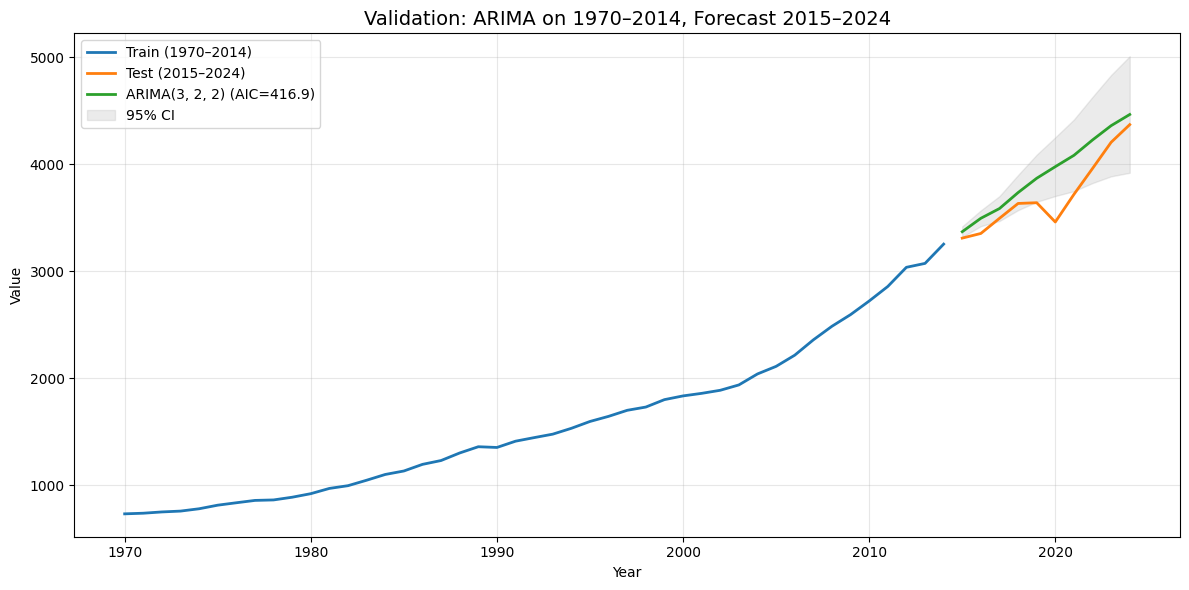

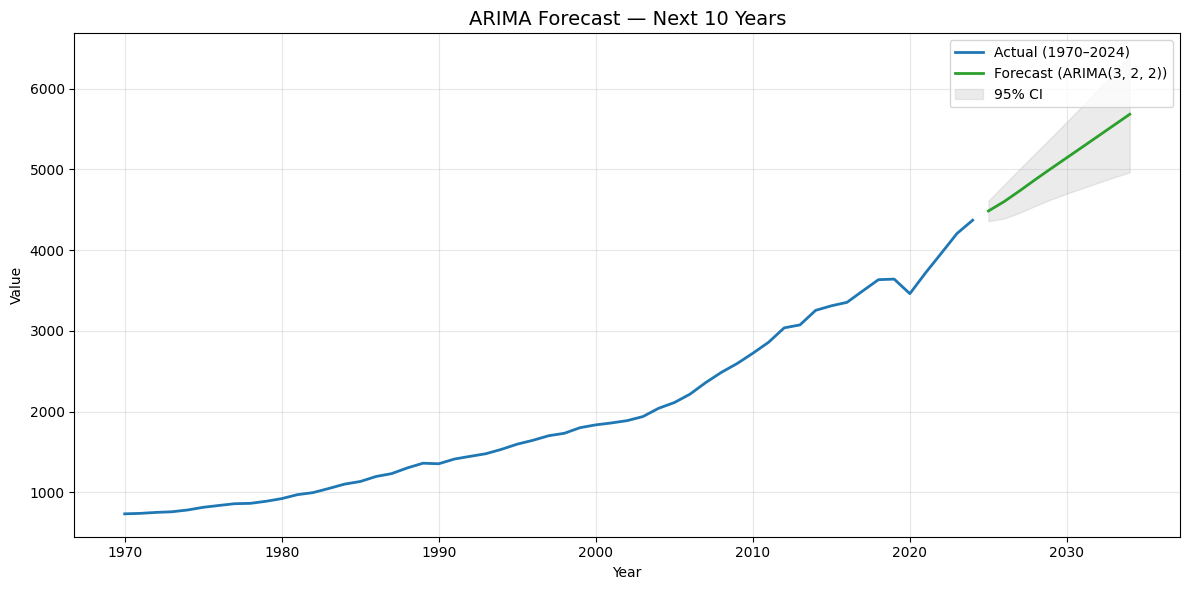

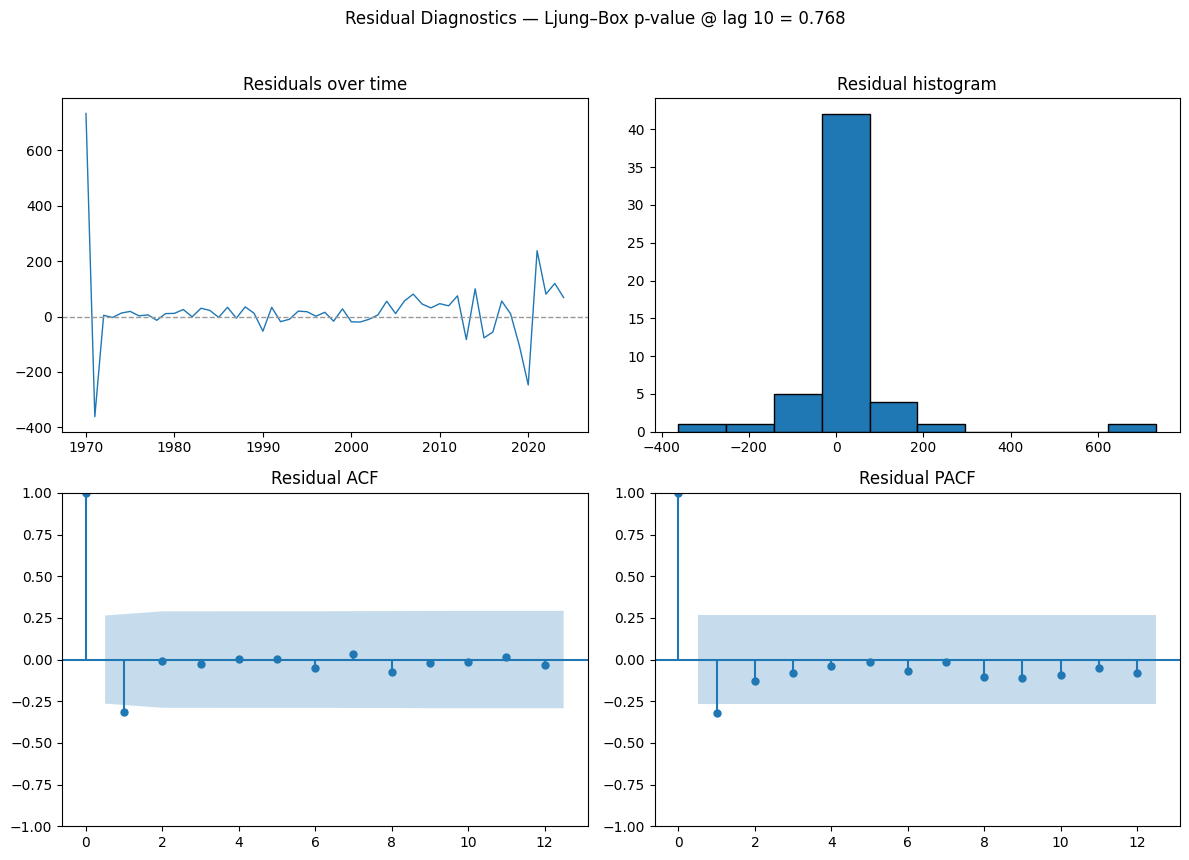

((3, 2, 2),
 416.85606869687894,
 202.10713933267192,
 244.72633598439234,
 5.504216128970594,
 0.4798348994519984,
 '/home/karan/pyKaran/CarbonEmissions/enhanced_arima_forecast1_10y.csv',
 '/home/karan/pyKaran/CarbonEmissions/Sheet1Plots/arima_validation_2015_2024.png',
 '/home/karan/pyKaran/CarbonEmissions/Sheet1Plots/arima_forecast_10y.png',
 '/home/karan/pyKaran/CarbonEmissions/Sheet1Plots/arima_residual_diagnostics.png')

In [25]:
# Enhanced ARIMA/SARIMA pipeline with diagnostics and 10-year forecast (corporate theme)
# Model selection via small AIC grid search
def select_arima_by_aic(series, p_range=range(0,4), d_range=range(0,3), q_range=range(0,4)):
    best = {"aic": np.inf, "order": None, "fit": None}
    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:
                    fit = ARIMA(series, order=(p,d,q)).fit()
                    if fit.aic < best["aic"]:
                        best = {"aic": fit.aic, "order": (p,d,q), "fit": fit}
                except Exception:
                    continue
    return best

best_train = select_arima_by_aic(train, range(0,4), range(0,3), range(0,4))
best_order = best_train["order"]
best_aic = best_train["aic"]
fit_train = best_train["fit"]

# Forecast on test to validate
pred_test_res = fit_train.get_forecast(steps=H)
pred_test_mean = pred_test_res.predicted_mean
pred_test_ci = pred_test_res.conf_int(alpha=0.05)

# Compute metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(test.values, pred_test_mean.values)
rmse = np.sqrt(mean_squared_error(test.values, pred_test_mean.values))
mape = np.mean(np.abs((test.values - pred_test_mean.values) / test.values)) * 100
r2 = r2_score(test.values, pred_test_mean.values)

# ------------------------
# Refit on full data and 10-year forecast
# ------------------------
fit_full = ARIMA(ts, order=best_order).fit()
steps = 10
fc_res = fit_full.get_forecast(steps=steps)
fc_mean = fc_res.predicted_mean
fc_ci = fc_res.conf_int(alpha=0.05)

# Save forecast table
future_years = pd.date_range(ts.index[-1] + pd.offsets.YearBegin(1), periods=steps, freq="YS")
forecast_df = pd.DataFrame({
    "Year": future_years.year,
    "Forecast": np.round(fc_mean.values, 3),
    "Lower_95": np.round(fc_ci.iloc[:,0].values, 3),
    "Upper_95": np.round(fc_ci.iloc[:,1].values, 3),
})
forecast_path = "/home/karan/pyKaran/CarbonEmissions/enhanced_arima_forecast1_10y.csv"
forecast_df.to_csv(forecast_path, index=False)


# ------------------------
# Diagnostics: residuals & Ljung–Box
# ------------------------
resid = fit_full.resid
lb = acorr_ljungbox(resid, lags=[10], return_df=True)  # 10 lags summary
lb_pvalue = float(lb["lb_pvalue"].iloc[0])

# ------------------------
# Corporate palette
# ------------------------
c_train = "#1f77b4"
c_test = "#ff7f0e"
c_fit = "#2ca02c"
c_ci = "#7f7f7f"

# ------------------------
# Plot 1: Train/Test fit (validation view)
# ------------------------
plt.figure(figsize=(12,6))
plt.plot(train.index, train.values, label="Train (1970–2014)", linewidth=2, color=c_train)
plt.plot(test.index, test.values, label="Test (2015–2024)", linewidth=2, color=c_test)
plt.plot(test.index, pred_test_mean.values, label=f"ARIMA{best_order} (AIC={best_aic:.1f})", linewidth=2, color=c_fit)
plt.fill_between(test.index,
                 pred_test_ci.iloc[:,0].values,
                 pred_test_ci.iloc[:,1].values,
                 alpha=0.15, label="95% CI", color=c_ci)
plt.title("Validation: ARIMA on 1970–2014, Forecast 2015–2024", fontsize=14)
plt.xlabel("Year"); plt.ylabel("Value")
plt.grid(alpha=0.3); plt.legend()
plt.tight_layout()
plot_valid_path = "/home/karan/pyKaran/CarbonEmissions/Sheet1Plots/arima_validation_2015_2024.png"
plt.savefig(plot_valid_path, dpi=150)
plt.show()

# ------------------------
# Plot 2: Full-series fit + 10-year forecast
# ------------------------
plt.figure(figsize=(12,6))
plt.plot(ts.index, ts.values, label="Actual (1970–2024)", linewidth=2, color=c_train)
future_index = future_years
plt.plot(future_index, fc_mean.values, label=f"Forecast (ARIMA{best_order})", linewidth=2, color=c_fit)
plt.fill_between(future_index, fc_ci.iloc[:,0].values, fc_ci.iloc[:,1].values, alpha=0.15, color=c_ci, label="95% CI")
plt.title("ARIMA Forecast — Next 10 Years", fontsize=14)
plt.xlabel("Year"); plt.ylabel("Value")
plt.grid(alpha=0.3); plt.legend()
plt.tight_layout()
plot_forecast_path = "/home/karan/pyKaran/CarbonEmissions/Sheet1Plots/arima_forecast_10y.png"
plt.savefig(plot_forecast_path, dpi=150)
plt.show()

# ------------------------
# Plot 3: Residual diagnostics (time series + ACF + PACF + histogram)
# ------------------------
fig, axes = plt.subplots(2,2, figsize=(12,9))

# residuals over time
axes[0,0].plot(resid, linewidth=1, color=c_train)
axes[0,0].axhline(0, linestyle="--", linewidth=1, color="#999999")
axes[0,0].set_title("Residuals over time")

# histogram
axes[0,1].hist(resid, bins=10, edgecolor="black")
axes[0,1].set_title("Residual histogram")

# ACF
plot_acf(resid, ax=axes[1,0], lags=12, title="Residual ACF")

# PACF
plot_pacf(resid, ax=axes[1,1], lags=12, title="Residual PACF", method="yw")

plt.suptitle(f"Residual Diagnostics — Ljung–Box p-value @ lag 10 = {lb_pvalue:.3f}", fontsize=12, y=0.98)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
diag_path = "/home/karan/pyKaran/CarbonEmissions/Sheet1Plots/arima_residual_diagnostics.png"
plt.savefig(diag_path, dpi=150)
plt.show()

# Summarize key numbers for the chat reply
(best_order, best_aic, mae, rmse, mape, r2, forecast_path, plot_valid_path, plot_forecast_path, diag_path)


In [26]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import numpy as np

def polynomial_regression_forecast(train_series, test_series, degree=2):
    # Create time index (0,1,2,...)
    t_train = np.arange(len(train_series)).reshape(-1,1)
    t_test = np.arange(len(train_series), len(train_series) + len(test_series)).reshape(-1,1)

    # Build model
    model = Pipeline([
        ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
        ("lr", LinearRegression())
    ])

    # Fit
    model.fit(t_train, train_series.values)

    # Predict
    preds = model.predict(t_test)

    return preds, model


# Try degree 2 and 3
poly2_preds, poly2_model = polynomial_regression_forecast(train, test, degree=2)
poly3_preds, poly3_model = polynomial_regression_forecast(train, test, degree=3)

# Evaluate using your updated compute_metrics
poly2_metrics = compute_metrics(test.values, poly2_preds)
poly3_metrics = compute_metrics(test.values, poly3_preds)

poly2_metrics, poly3_metrics


({'MSE': 17973.99398420067,
  'RMSE': 134.06712491957404,
  'MSLE': 0.0013227044234053052,
  'MAE': 114.2834063706102,
  'MAPE': 3.1043449428421366,
  'ACCURACY': 96.89565505715787,
  'MEDIAN AE': 123.71597086736847,
  'MAX ERROR': 265.0929345982254,
  'R2 SCORE': 0.843892277897369,
  'EVS': 0.8557620563923745},
 {'MSE': 196078.9414443332,
  'RMSE': 442.80801872180814,
  'MSLE': 0.01168604817057851,
  'MAE': 381.1283635521418,
  'MAPE': 10.018177786893705,
  'ACCURACY': 89.9818222131063,
  'MEDIAN AE': 428.9871363589425,
  'MAX ERROR': 693.4655090610818,
  'R2 SCORE': -0.7029847082443685,
  'EVS': 0.5586171933188554})

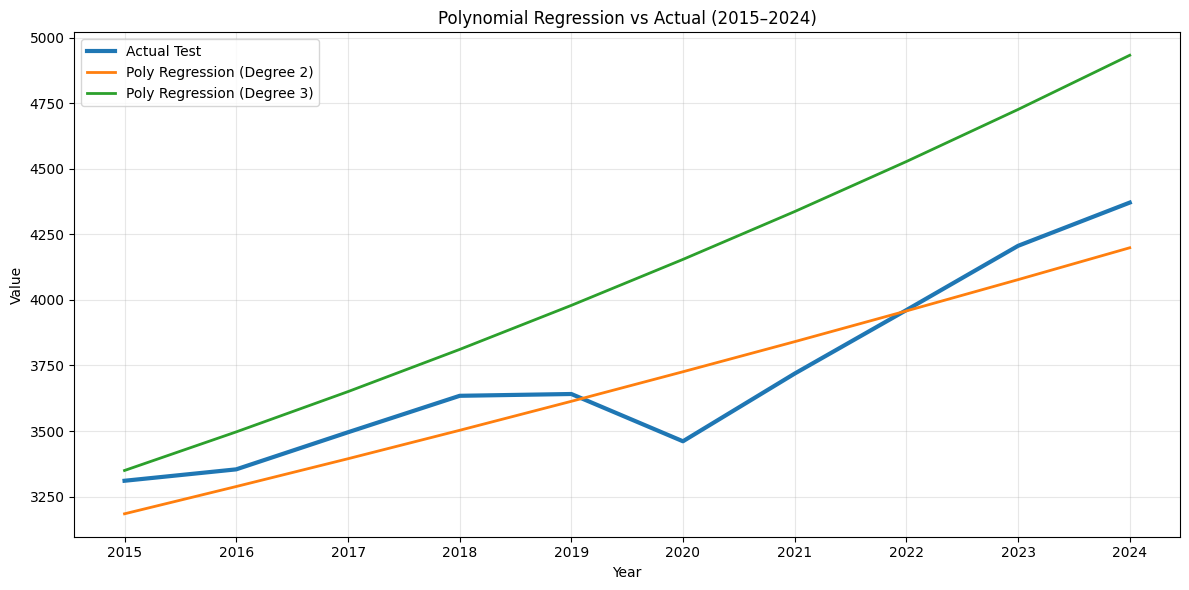

In [27]:
plt.figure(figsize=(12,6))
plt.plot(test.index, test.values, label="Actual Test", linewidth=3)
plt.plot(test.index, poly2_preds, label="Poly Regression (Degree 2)", linewidth=2)
plt.plot(test.index, poly3_preds, label="Poly Regression (Degree 3)", linewidth=2)
plt.title("Polynomial Regression vs Actual (2015–2024)")
plt.xlabel("Year")
plt.ylabel("Value")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


**Structural Breaks**

In [ ]:
# Utility functions
def rss_linear(y, X):
    beta = np.linalg.lstsq(X, y, rcond=None)[0]
    resid = y - X @ beta
    return float(resid.T @ resid), beta

def bic_from_rss(rss, n, k):
    # BIC = n*log(rss/n) + k*log(n)
    return n * np.log(rss / n) + k * np.log(n)

def design_matrix_with_breaks(t, breaks):
    # t is integer index 0..N-1
    # breaks is sorted list of break indices (exclusive): split at these indices
    # Piecewise linear with continuity at breaks ("broken-stick" with hinge functions)
    n = len(t)
    X = np.ones((n, 1))  # intercept
    # baseline linear trend
    X = np.column_stack([X, t])
    for b in breaks:
        # hinge term: (t - b)_+
        hinge = np.maximum(0, t - b)
        X = np.column_stack([X, hinge])
    return X

def exhaustive_break_search(y, max_breaks=3, min_seg=5):
    """
    Exhaustive search over combinations of breakpoints up to max_breaks.
    Uses BIC to select the best model among k=0..max_breaks breaks.
    Returns dict with best breaks, BIC, RSS and betas.
    """
    n = len(y)
    t = np.arange(n)
    best = {"breaks": [], "bic": np.inf, "rss": None, "betas": None}
    # Candidate break positions (indices between segments)
    candidates = list(range(min_seg, n - min_seg + 1))
    # Always evaluate k=0 (no breaks)
    X0 = design_matrix_with_breaks(t, [])
    rss0, beta0 = rss_linear(y, X0)
    bic0 = bic_from_rss(rss0, n, X0.shape[1])
    if bic0 < best["bic"]:
        best = {"breaks": [], "bic": bic0, "rss": rss0, "betas": beta0}
    # Evaluate k=1..max_breaks
    for k in range(1, max_breaks + 1):
        for combo in itertools.combinations(candidates, k):
            # Ensure minimum segment length between breaks
            valid = True
            prev = 0
            for b in combo + (n,):
                if b - prev < min_seg:
                    valid = False
                    break
                prev = b
            if not valid:
                continue
            X = design_matrix_with_breaks(t, list(combo))
            rss, betas = rss_linear(y, X)
            bic = bic_from_rss(rss, n, X.shape[1])
            if bic < best["bic"]:
                best = {"breaks": list(combo), "bic": bic, "rss": rss, "betas": betas}
    return best

# Utility functions
def rss_linear(y, X):
    beta = np.linalg.lstsq(X, y, rcond=None)[0]
    resid = y - X @ beta
    return float(resid.T @ resid), beta

def bic_from_rss(rss, n, k):
    # BIC = n*log(rss/n) + k*log(n)
    return n * np.log(rss / n) + k * np.log(n)

def design_matrix_with_breaks(t, breaks):
    # t is integer index 0..N-1
    # breaks is sorted list of break indices (exclusive): split at these indices
    # Piecewise linear with continuity at breaks ("broken-stick" with hinge functions)
    n = len(t)
    X = np.ones((n, 1))  # intercept
    # baseline linear trend
    X = np.column_stack([X, t])
    for b in breaks:
        # hinge term: (t - b)_+
        hinge = np.maximum(0, t - b)
        X = np.column_stack([X, hinge])
    return X

def exhaustive_break_search(y, max_breaks=3, min_seg=5):
    """
    Exhaustive search over combinations of breakpoints up to max_breaks.
    Uses BIC to select the best model among k=0..max_breaks breaks.
    Returns dict with best breaks, BIC, RSS and betas.
    """
    n = len(y)
    t = np.arange(n)
    best = {"breaks": [], "bic": np.inf, "rss": None, "betas": None}
    # Candidate break positions (indices between segments)
    candidates = list(range(min_seg, n - min_seg + 1))
    # Always evaluate k=0 (no breaks)
    X0 = design_matrix_with_breaks(t, [])
    rss0, beta0 = rss_linear(y, X0)
    bic0 = bic_from_rss(rss0, n, X0.shape[1])
    if bic0 < best["bic"]:
        best = {"breaks": [], "bic": bic0, "rss": rss0, "betas": beta0}
    # Evaluate k=1..max_breaks
    for k in range(1, max_breaks + 1):
        for combo in itertools.combinations(candidates, k):
            # Ensure minimum segment length between breaks
            valid = True
            prev = 0
            for b in combo + (n,):
                if b - prev < min_seg:
                    valid = False
                    break
                prev = b
            if not valid:
                continue
            X = design_matrix_with_breaks(t, list(combo))
            rss, betas = rss_linear(y, X)
            bic = bic_from_rss(rss, n, X.shape[1])
            if bic < best["bic"]:
                best = {"breaks": list(combo), "bic": bic, "rss": rss, "betas": betas}
    return best

In [36]:
def chow_test_at_year(ts, year):
    # Build OLS with and without interactions
    y = ts.values
    t = np.arange(len(ts))
    # Dummy for post-break
    d = (ts.index.year > year).astype(int)
    # Model with different intercept and slope after break
    X = np.column_stack([np.ones(len(t)), t, d, d * t])
    ols_full = sm.OLS(y, X).fit()
    # Restricted (no break): common intercept & slope
    Xr = sm.add_constant(t)
    ols_restr = sm.OLS(y, Xr).fit()
    # Chow F-stat manually
    rss_r = sum(ols_restr.resid**2)
    rss_u = sum(ols_full.resid**2)
    k = X.shape[1] - Xr.shape[1]  # added parameters
    n = len(y)
    f_stat = ((rss_r - rss_u) / k) / (rss_u / (n - X.shape[1]))
    from scipy.stats import f
    p_val = 1 - f.cdf(f_stat, k, n - X.shape[1])
    return {"F": float(f_stat), "p_value": float(p_val), "restricted_rss": float(rss_r),
            "unrestricted_rss": float(rss_u)}

chow_2020 = chow_test_at_year(ts, 2019)  

In [ ]:
#(2) Automatic breakpoint detection (BIC-based, Bai–Perron style)

best_breaks = exhaustive_break_search(ts.values, max_breaks=3, min_seg=5)
detected_break_indices = best_breaks["breaks"]
detected_break_years = [int(ts.index[b].year) for b in detected_break_indices]

# Build fitted piecewise curve
t = np.arange(len(ts))
X_best = design_matrix_with_breaks(t, detected_break_indices)
yhat_piecewise = X_best @ best_breaks["betas"]


In [38]:
# 3) ARIMA trained separately on each regime & Final forecast

def aic_search_arima(series, p_range=range(0,4), d_range=range(0,3), q_range=range(0,4)):
    best = {"aic": np.inf, "order": None, "fit": None}
    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:
                    fit = ARIMA(series, order=(p,d,q)).fit()
                    if fit.aic < best["aic"]:
                        best = {"aic": fit.aic, "order": (p,d,q), "fit": fit}
                except Exception:
                    continue
    return best

# Split regimes using detected breaks
all_breaks = detected_break_indices + [len(ts)]
start = 0
regimes = []
for b in all_breaks:
    seg = ts.iloc[start:b]
    regimes.append((start, b, seg))
    start = b

regime_info = []
for i, (s, e, seg) in enumerate(regimes, 1):
    best = aic_search_arima(seg)
    regime_info.append({
        "Regime": i,
        "Start_Year": int(seg.index[0].year),
        "End_Year": int(seg.index[-1].year),
        "Order": best["order"],
        "AIC": best["aic"]
    })

# Forecast next 10 years from last regime model
last_seg = regimes[-1][2]
last_best = aic_search_arima(last_seg)
fit_last = last_best["fit"]
steps = 10
fc_res = fit_last.get_forecast(steps=steps)
fc_mean = fc_res.predicted_mean
fc_ci = fc_res.conf_int(alpha=0.05)
future_years = pd.date_range(ts.index[-1] + pd.offsets.YearBegin(1), periods=steps, freq="YS")
forecast_df = pd.DataFrame({
    "Year": future_years.year,
    "Forecast": np.round(fc_mean.values, 3),
    "Lower_95": np.round(fc_ci.iloc[:,0].values, 3),
    "Upper_95": np.round(fc_ci.iloc[:,1].values, 3),
})

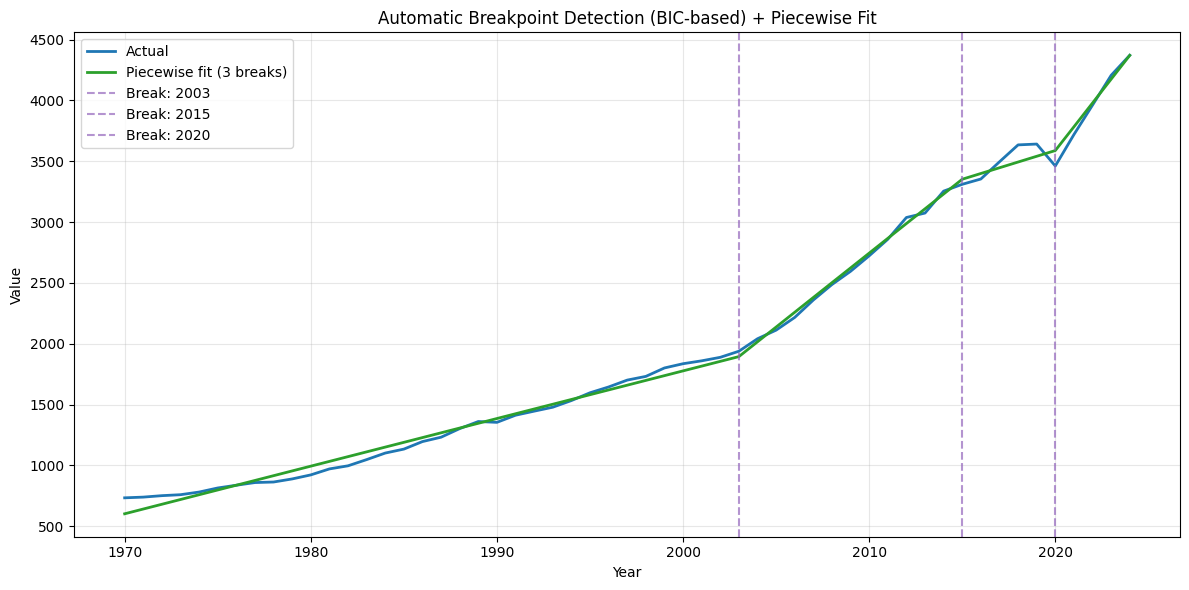

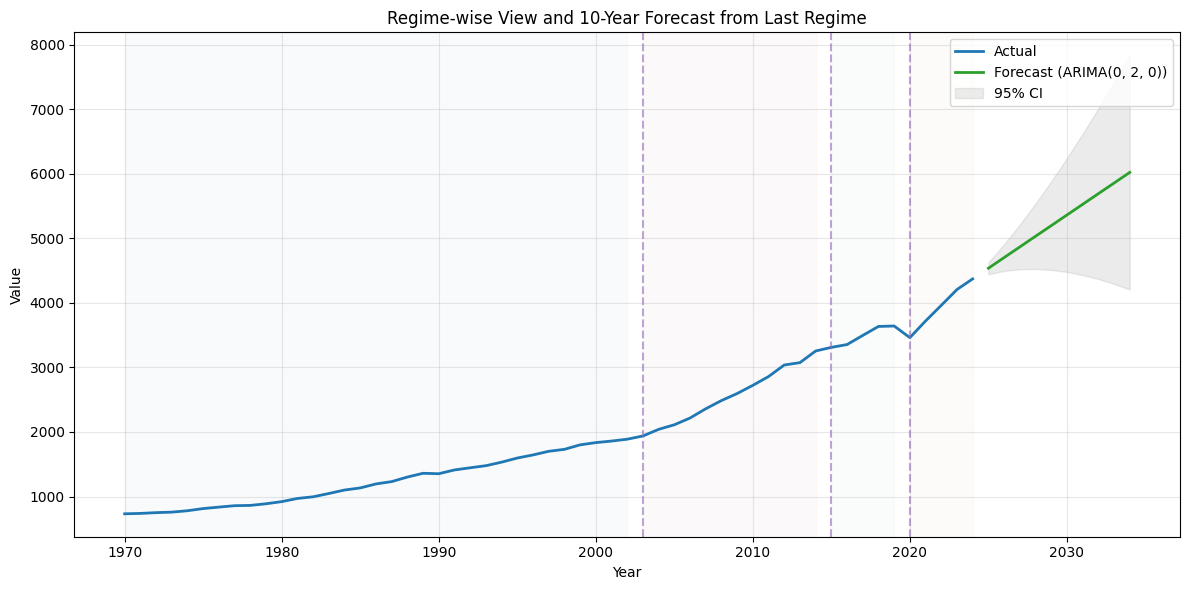

('/home/karan/pyKaran/CarbonEmissions/Sheet1csv/chow_test_2020.csv',
 '/home/karan/pyKaran/CarbonEmissions/Sheet1csv/detected_breaks.csv',
 '/home/karan/pyKaran/CarbonEmissions/Sheet1csv/regime_arima_summary.csv',
 '/home/karan/pyKaran/CarbonEmissions/Sheet1csv/final_forecast_10y_from_last_regime.csv',
 '/home/karan/pyKaran/CarbonEmissions/Sheet1Plots/breaks_piecewise_fit.png',
 '/home/karan/pyKaran/CarbonEmissions/Sheet1Plots/regimes_and_forecast.png',
 [2003, 2015, 2020])

In [39]:
# Plots (corporate style)

c_actual = "#1f77b4"; c_piece = "#2ca02c"; c_break = "#9467bd"; c_fc = "#2ca02c"; c_ci = "#7f7f7f"

# Plot A: Piecewise fit with detected breaks
plt.figure(figsize=(12,6))
plt.plot(ts.index, ts.values, label="Actual", color=c_actual, linewidth=2)
plt.plot(ts.index, yhat_piecewise, label=f"Piecewise fit ({len(detected_break_indices)} breaks)", color=c_piece, linewidth=2)
for b in detected_break_indices:
    year = ts.index[b].year
    plt.axvline(ts.index[b], color=c_break, linestyle="--", alpha=0.7, label=f"Break: {year}")
plt.title("Automatic Breakpoint Detection (BIC-based) + Piecewise Fit")
plt.xlabel("Year"); plt.ylabel("Value")
plt.grid(alpha=0.3)
# Avoid duplicate legend entries for multiple breaks
handles, labels = plt.gca().get_legend_handles_labels()
from collections import OrderedDict
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.tight_layout()
plot_piece_path = "/home/karan/pyKaran/CarbonEmissions/Sheet1Plots/breaks_piecewise_fit.png"
plt.savefig(plot_piece_path, dpi=150)
plt.show()

# Plot B: Regimes + final 10-year forecast from last regime ARIMA
plt.figure(figsize=(12,6))
plt.plot(ts.index, ts.values, label="Actual", color=c_actual, linewidth=2)
# Regime shading
prev = 0
colors = ["#E8EEF7", "#F7E8EF", "#E8F7EF", "#F7F3E8"]
for i, b in enumerate(all_breaks):
    plt.axvspan(ts.index[prev], ts.index[b-1], color=colors[i % len(colors)], alpha=0.25)
    prev = b
# Forecast with CI
plt.plot(future_years, fc_mean.values, color=c_fc, linewidth=2, label=f"Forecast (ARIMA{last_best['order']})")
plt.fill_between(future_years, fc_ci.iloc[:,0].values, fc_ci.iloc[:,1].values, color=c_ci, alpha=0.15, label="95% CI")
for b in detected_break_indices:
    plt.axvline(ts.index[b], color=c_break, linestyle="--", alpha=0.6)
plt.title("Regime-wise View and 10-Year Forecast from Last Regime")
plt.xlabel("Year"); plt.ylabel("Value")
plt.grid(alpha=0.3); plt.legend()
plt.tight_layout()
plot_regime_fc_path = "/home/karan/pyKaran/CarbonEmissions/Sheet1Plots/regimes_and_forecast.png"
plt.savefig(plot_regime_fc_path, dpi=150)
plt.show()

# -----------------------------
# Tables to download
# -----------------------------
# Chow result
chow_df = pd.DataFrame([chow_2020])
chow_path = "/home/karan/pyKaran/CarbonEmissions/Sheet1csv/chow_test_2020.csv"
chow_df.to_csv(chow_path, index=False)

# Detected breaks
breaks_df = pd.DataFrame({
    "Break_Index": detected_break_indices,
    "Break_Year": detected_break_years
})
breaks_path = "/home/karan/pyKaran/CarbonEmissions/Sheet1csv/detected_breaks.csv"
breaks_df.to_csv(breaks_path, index=False)

# Regime ARIMA table
regimes_df = pd.DataFrame(regime_info)
regimes_path = "/home/karan/pyKaran/CarbonEmissions/Sheet1csv/regime_arima_summary.csv"
regimes_df.to_csv(regimes_path, index=False)

# Forecast table
forecast_path = "/home/karan/pyKaran/CarbonEmissions/Sheet1csv/final_forecast_10y_from_last_regime.csv"
forecast_df.to_csv(forecast_path, index=False)


(chow_path, breaks_path, regimes_path, forecast_path, plot_piece_path, plot_regime_fc_path, detected_break_years)


**Custom Intervals**

In [42]:
# Custom intervals
intervals = [
    ("1990", "2008"),
    ("2008", "2012"),
    ("2012", "2017"),
    ("2017", "2024")
]

results = []
interval_trends = {}

# Fit trend (linear regression) for each interval
for start, end in intervals:
    segment = ts[start:end]
    y = segment.values
    t = np.arange(len(segment)).reshape(-1, 1)

    # Fit regression
    reg = LinearRegression().fit(t, y)
    slope = reg.coef_[0]
    intercept = reg.intercept_
    r2 = reg.score(t, y)

    # Statsmodels for p-value
    X = sm.add_constant(t)
    model = sm.OLS(y, X).fit()
    p_value = model.pvalues[1]

    results.append({
        "Interval": f"{start}-{end}",
        "Slope": slope,
        "Intercept": intercept,
        "R²": r2,
        "Slope p-value": p_value,
        "Avg Annual Growth": slope
    })

    interval_trends[(start, end)] = (segment.index, segment.values, slope, intercept)

# Convert to DataFrame
trend_table = pd.DataFrame(results)
trend_table_path = "/home/karan/pyKaran/CarbonEmissions/Sheet1csv/interval_trend_analysis.csv"
trend_table.to_csv(trend_table_path, index=False)
print(trend_table)


    Interval       Slope    Intercept        R²  Slope p-value  \
0  1990-2008   56.186162  1306.550169  0.961499   1.838312e-13   
1  2008-2012  136.525787  2467.024737  0.991127   3.556842e-04   
2  2012-2017   91.014713  3026.768042  0.961823   5.536672e-04   
3  2017-2024  121.528759  3386.006159  0.792142   3.057092e-03   

   Avg Annual Growth  
0          56.186162  
1         136.525787  
2          91.014713  
3         121.528759  


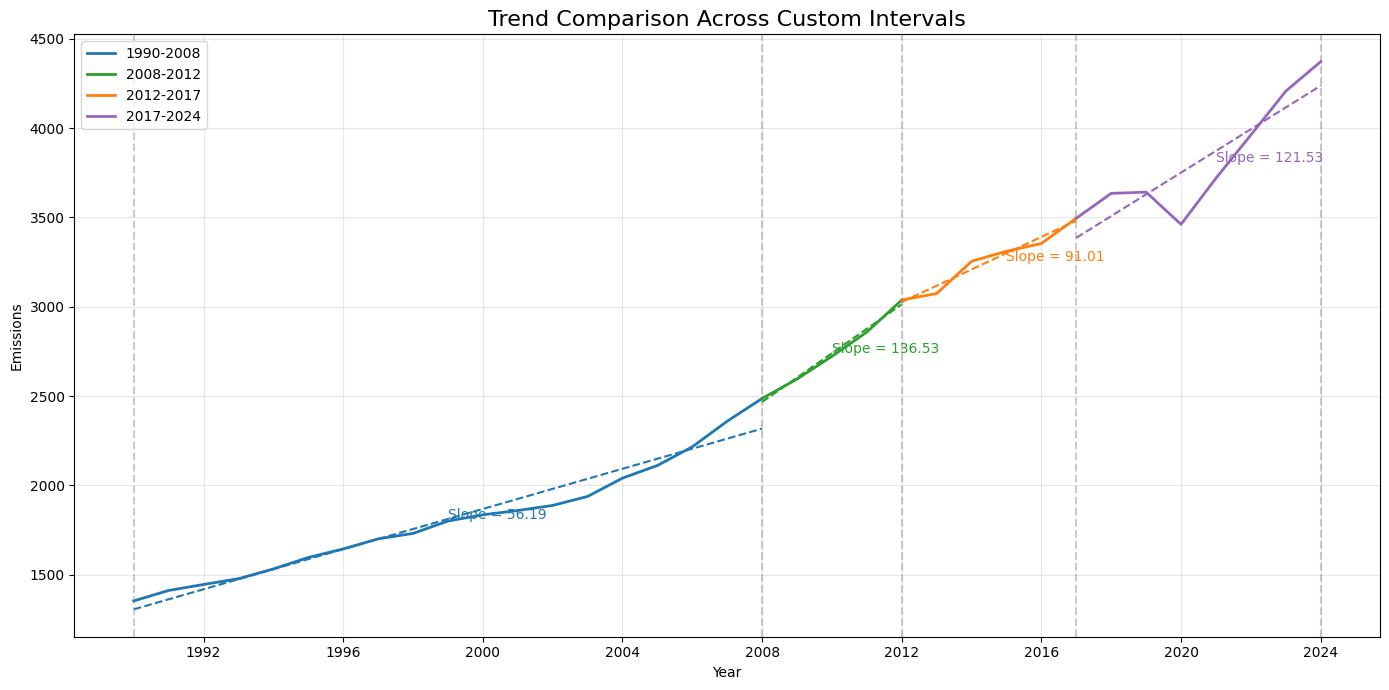

In [43]:
# Corporate colors
colors = ["#1f77b4", "#2ca02c", "#ff7f0e", "#9467bd"]

plt.figure(figsize=(14,7))
for i, (start, end) in enumerate(intervals):
    idx, vals, slope, intercept = interval_trends[(start, end)]
    t = np.arange(len(vals))
    y_hat = intercept + slope * t

    plt.plot(idx, vals, color=colors[i], linewidth=2, label=f"{start}-{end}")
    plt.plot(idx, y_hat, color=colors[i], linestyle="--")

    # Label slope on plot
    mid = idx[len(idx)//2]
    plt.text(mid, np.mean(vals), f"Slope = {slope:.2f}", color=colors[i], fontsize=10)

# Vertical lines at boundaries
bounds = ["1990", "2008", "2012", "2017", "2024"]
for b in bounds:
    plt.axvline(pd.to_datetime(b), color="#7f7f7f", linestyle="--", alpha=0.4)

plt.title("Trend Comparison Across Custom Intervals", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Emissions")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
pp = "/home/karan/pyKaran/CarbonEmissions/Sheet1Plots/trend_comparison_intervals.png"
plt.savefig(pp, dpi=150)
plt.show()


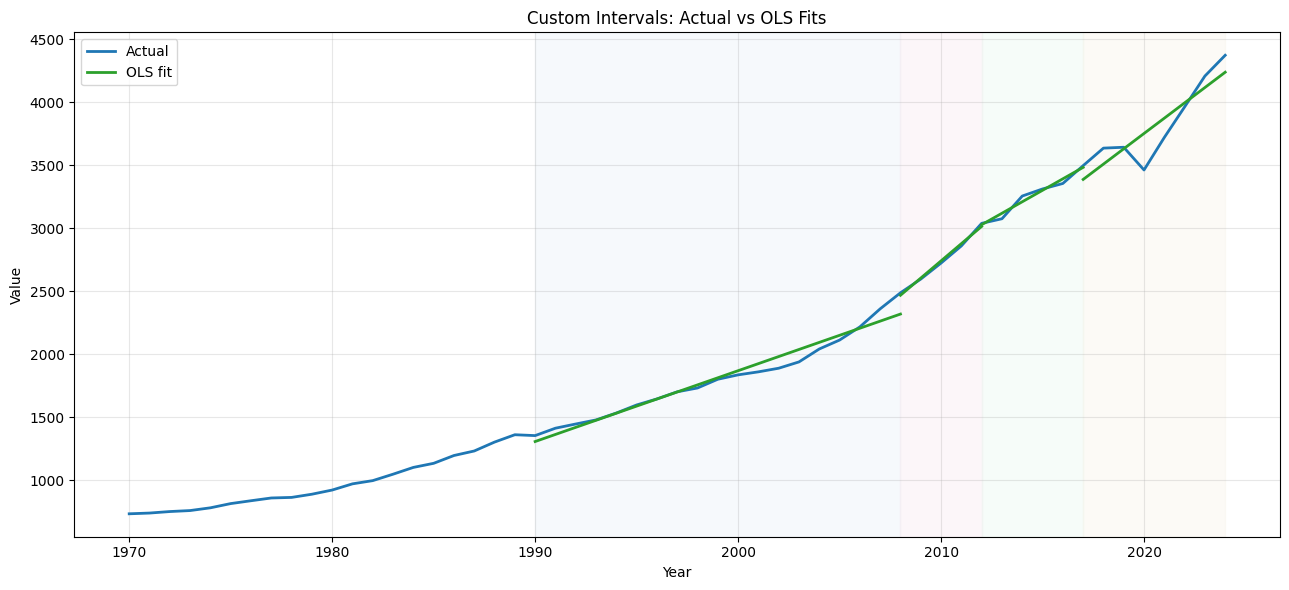

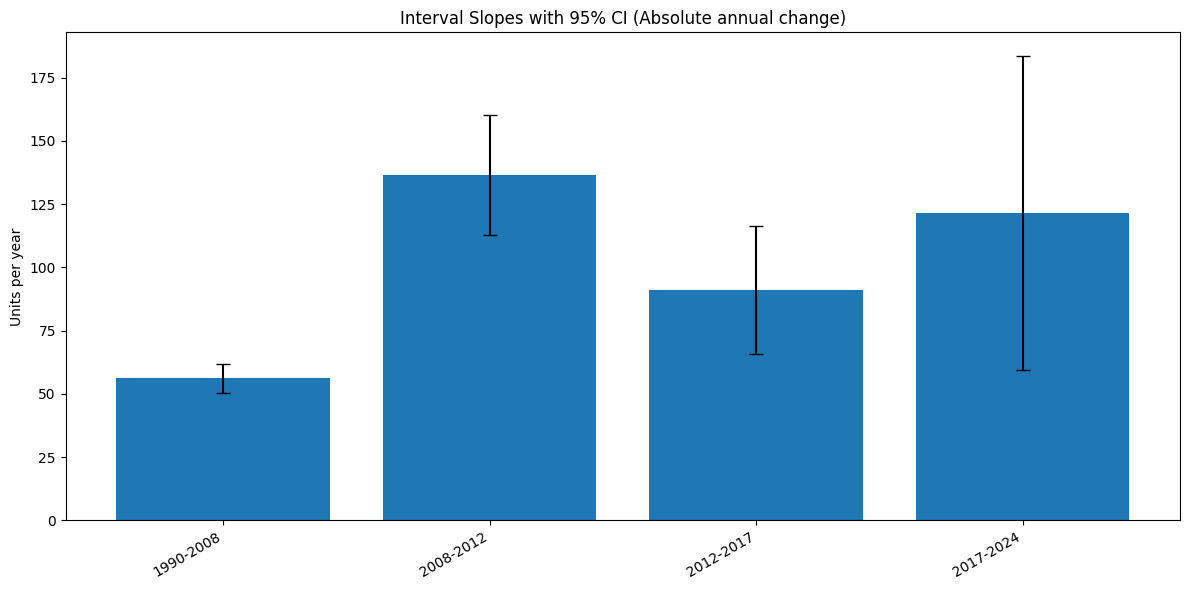

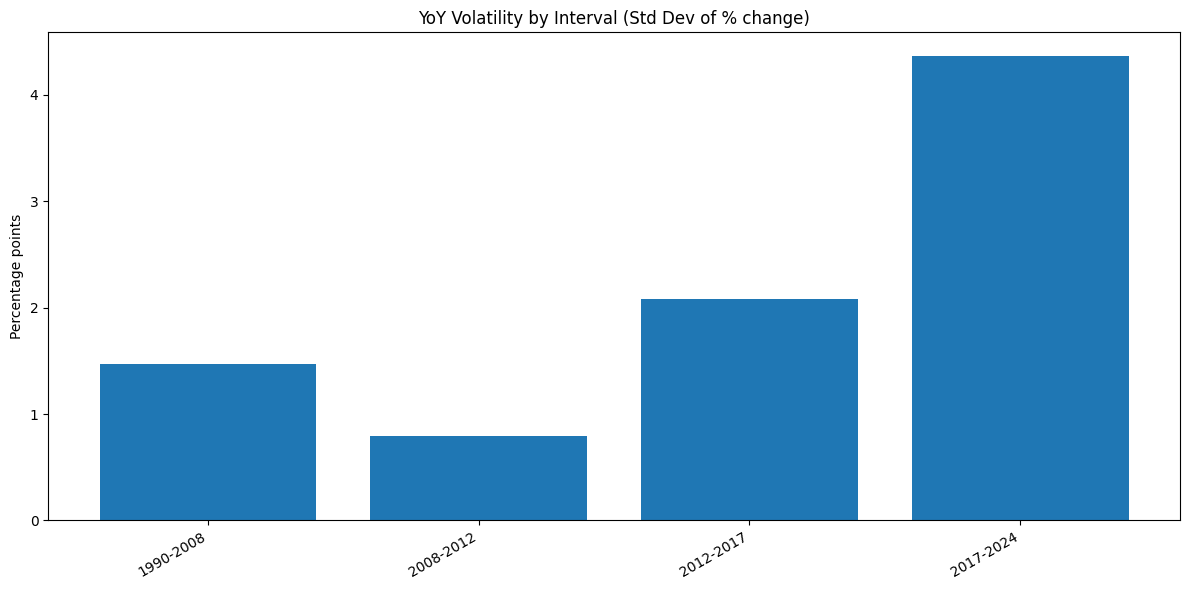

In [44]:
# Custom-interval trend analysis: compute rich metrics, produce plots & tables, and write a markdown report.
# Intervals:
#  - 1990–2008
#  - 2008–2012
#  - 2012–2017
#  - 2017–2024

def interval_metrics(series):
    """Return dict of slope, intercept, R2, p-value, AvgAnnualGrowth, RMSE, MAE, MAPE, YoY std, sample size."""
    y = series.values
    # Time index in years from first year
    t = (series.index.year - series.index.year[0]).astype(float)
    X = sm.add_constant(t)
    model = sm.OLS(y, X).fit()
    slope = model.params[1]
    intercept = model.params[0]
    r2 = model.rsquared
    pval = model.pvalues[1]
    # fitted and errors
    yhat = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    mae = mean_absolute_error(y, yhat)
    mape = np.mean(np.abs((y - yhat) / np.maximum(y, 1e-9))) * 100
    # avg annual growth (absolute) = slope; relative CAGR:
    n_years = len(series) - 1 if len(series) > 1 else 1
    cagr = (series.iloc[-1] / series.iloc[0]) ** (1 / n_years) - 1 if n_years > 0 else 0.0
    # YoY changes and volatility
    yoy = series.pct_change().dropna()
    yoy_mean = yoy.mean()
    yoy_std = yoy.std()
    # slope CI
    slope_se = model.bse[1]
    from scipy.stats import t as tdist
    dof = len(y) - 2
    tcrit = tdist.ppf(0.975, dof) if dof > 0 else np.nan
    slope_ci_low = slope - tcrit * slope_se if dof > 0 else np.nan
    slope_ci_high = slope + tcrit * slope_se if dof > 0 else np.nan
    return {
        "Start": int(series.index[0].year),
        "End": int(series.index[-1].year),
        "N": int(len(series)),
        "Slope": slope,
        "Slope_95%_Low": slope_ci_low,
        "Slope_95%_High": slope_ci_high,
        "Intercept": intercept,
        "R2": r2,
        "Slope_p": pval,
        "Avg_Annual_Growth(abs)": slope,
        "CAGR(%)": cagr * 100,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE(%)": mape,
        "YoY_Mean(%)": yoy_mean * 100 if len(yoy) else np.nan,
        "YoY_Std(%)": yoy_std * 100 if len(yoy) else np.nan,
    }, model, yhat

# Compute metrics per interval
rows = []
fits = {}
for (s, e) in intervals:
    seg = ts[s:e]
    # inclusive of end year
    seg = seg[seg.index.year >= int(s)]
    seg = seg[seg.index.year <= int(e)]
    metrics, model, yhat = interval_metrics(seg)
    metrics["Interval"] = f"{s}-{e}"
    rows.append(metrics)
    fits[(s,e)] = {"series": seg, "yhat": yhat, "model": model}

metrics_df = pd.DataFrame(rows).set_index("Interval")

metrics_csv = "/home/karan/pyKaran/CarbonEmissions/Sheet1csv/interval_trend_metrics.csv"
metrics_df.to_csv(metrics_csv)

# ------------------------
# Plots
# ------------------------
# Corporate palette
c_actual = "#1f77b4"
c_fit = "#2ca02c"
c_ci = "#7f7f7f"

# Plot A: Actual + interval OLS fits
plt.figure(figsize=(13,6))
plt.plot(ts.index, ts.values, color=c_actual, label="Actual", linewidth=2)
colors = ["#E8EEF7", "#F7E8EF", "#E8F7EF", "#F7F3E8"]
for i,(s,e) in enumerate(intervals):
    seg = fits[(s,e)]["series"]
    yhat = fits[(s,e)]["yhat"]
    plt.axvspan(seg.index[0], seg.index[-1], color=colors[i%len(colors)], alpha=0.35)
    plt.plot(seg.index, yhat, color=c_fit, linewidth=2, label="OLS fit" if i==0 else None)
plt.title("Custom Intervals: Actual vs OLS Fits")
plt.xlabel("Year"); plt.ylabel("Value")
plt.grid(alpha=0.3); plt.legend()
plt.tight_layout()
plot_fit_path = "/home/karan/pyKaran/CarbonEmissions/Sheet1Plots/custom_intervals_fit.png"
plt.savefig(plot_fit_path, dpi=150)
plt.show()

# Plot B: Bar chart of slopes with 95% CI
plt.figure(figsize=(12,6))
idx = metrics_df.index.tolist()
slopes = metrics_df["Slope"].values
ci_low = metrics_df["Slope_95%_Low"].values
ci_high = metrics_df["Slope_95%_High"].values
yerr = np.vstack([slopes - ci_low, ci_high - slopes])
plt.bar(idx, slopes)
plt.errorbar(idx, slopes, yerr=yerr, fmt='none', ecolor='black', capsize=5)
plt.title("Interval Slopes with 95% CI (Absolute annual change)")
plt.ylabel("Units per year")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plot_slope_path = "/home/karan/pyKaran/CarbonEmissions/Sheet1Plots/custom_intervals_slopes.png"
plt.savefig(plot_slope_path, dpi=150)
plt.show()

# Plot C: YoY volatility per interval
plt.figure(figsize=(12,6))
plt.bar(idx, metrics_df["YoY_Std(%)"].values)
plt.title("YoY Volatility by Interval (Std Dev of % change)")
plt.ylabel("Percentage points")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plot_vol_path = "/home/karan/pyKaran/CarbonEmissions/Sheet1Plots/custom_intervals_volatility.png"
plt.savefig(plot_vol_path, dpi=150)
plt.show()



In [45]:
df = pd.read_csv("/home/karan/pyKaran/CarbonEmissions/carbon emissions data - Sheet5.csv")

In [46]:
df

,ISO,Country,Data source,Sector,Gas,Unit,2022,2021,2020,2019,...,1999,1998,1997,1996,1995,1994,1993,1992,1991,1990
0,WORLD,World,Climate Watch,Total including LUCF,All GHG,MtCO₂e,50809.05,50356.43,48271.97,50603.57,...,36237.04,36252.91,36750.40,35360.41,34975.22,34164.05,33902.13,33716.50,33767.18,33589.16
1,IND,India,Climate Watch,Total including LUCF,All GHG,MtCO₂e,3805.03,3584.74,3326.20,3507.03,...,1580.92,1499.21,1470.03,1410.07,1361.15,1293.11,1244.03,1208.14,1181.45,1126.56


In [47]:
india_row = df[df["ISO"] == "IND"].iloc[0]
world_row = df[df["ISO"] == "WORLD"].iloc[0]

# ---------------------------
# 2. Select year columns 1990–2022
# ---------------------------
years = [str(y) for y in range(1990, 2023)]  # inclusive 1990–2022

india_ts = india_row[years].astype(float)
world_ts = world_row[years].astype(float)

# Convert to datetime index
india_ts.index = pd.to_datetime(india_ts.index, format="%Y")
world_ts.index = pd.to_datetime(world_ts.index, format="%Y")

india_ts.name = "India"
world_ts.name = "World"


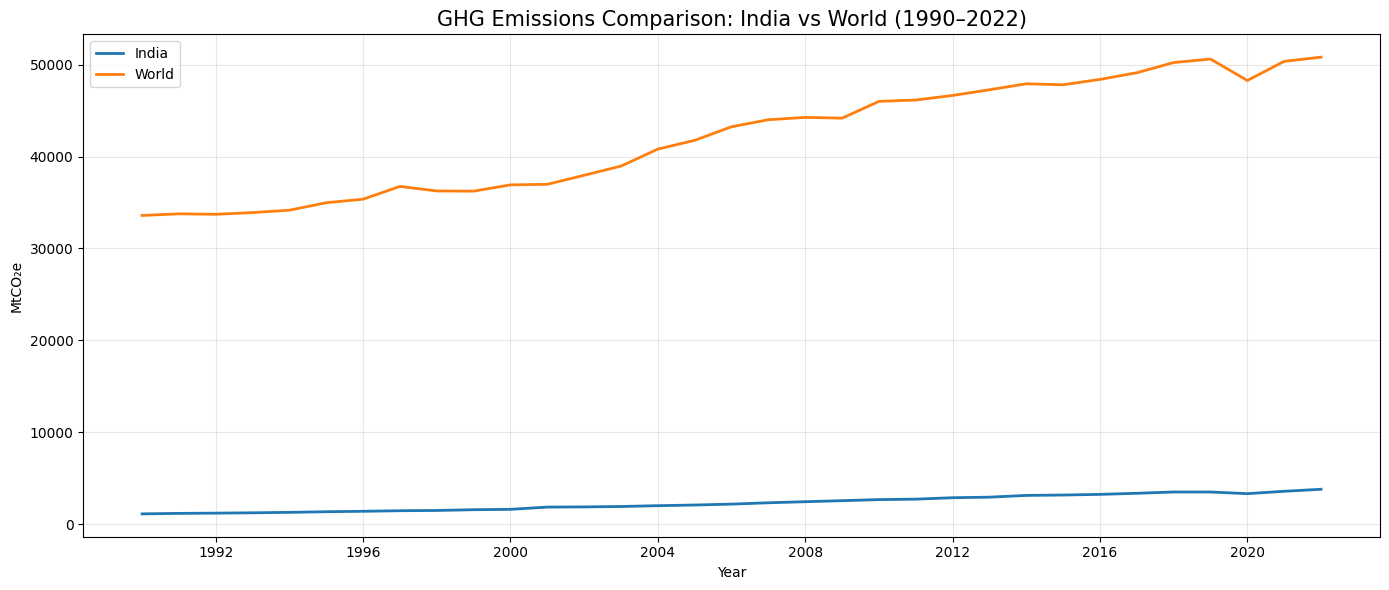

<Figure size 640x480 with 0 Axes>

In [48]:
plt.figure(figsize=(14,6))

plt.plot(india_ts.index, india_ts.values, label="India", color="#1f77b4", linewidth=2)
plt.plot(world_ts.index, world_ts.values, label="World", color="#ff7f0e", linewidth=2)

plt.title("GHG Emissions Comparison: India vs World (1990–2022)", fontsize=15)
plt.xlabel("Year")
plt.ylabel("MtCO₂e")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig("/home/karan/pyKaran/CarbonEmissions/india_vs_world_emissions.png", dpi=150)